In [ ]:
!pip install spectral
!pip install rasterio

     |████████████████████████████████| 212 kB 5.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
#Bibliotecas
import numpy as np
import rasterio as rio
import matplotlib
from spectral import imshow
import skimage.color as color
from skimage.transform import rescale
import cv2 

In [ ]:
# Parâmetro de tamanho das figuras
matplotlib.rcParams['figure.figsize'] = [12,8]

In [ ]:
# Lendo multiespectral
src1 = rio.open('/content/drive/MyDrive/Curso PDI com Python/mult.tif')
b1 = src1.read(1)
b2 = src1.read(2)
b3 = src1.read(3)
b4 = src1.read(4)

multi = np.dstack([b1,b2,b3,b4])

In [ ]:
# Lendo banda pan
src2 = rio.open('/content/drive/MyDrive/Curso PDI com Python/pan_cut.tif')
pan = src2.read(1)

In [ ]:
# Lendo imagem SAR
src3 = rio.open('/content/drive/MyDrive/Curso PDI com Python/VH.tif')
sar = src3.read(1)

In [ ]:
print(multi.shape, sar.shape, pan.shape)

(635, 700, 4) (517, 589) (2546, 2805)


In [ ]:
# Gravando metadados
meta_multi = src1.profile
meta_pan = src2.profile
meta_sar = src3.profile

In [ ]:
# Criando a função de resample

def resample(source, target, scale):
  scaled = np.empty((source.shape[0]*scale, source.shape[1]*scale, source.shape[2]))

  for i in range(4):
    img = source[:,:,i]
    s = rescale(img, (scale,scale))
    scaled[:,:,i] = s

  
  if target.shape[0] < scaled.shape[0]:
    scaled = scaled[:target.shape[0],:,:]
  else:
    target = target[:scaled.shape[0],:]

  if target.shape[1] < scaled.shape[1]:
    scaled = scaled[:,:target.shape[1],:]
  else:
    target = target[:,:scaled.shape[1]]

  B = scaled[:,:,0]
  G = scaled[:,:,1]
  R = scaled[:,:,2]
  I = scaled[:,:,3]

  return np.dstack([B,G,R,I]), target

In [ ]:
# Criando função IHS

def IHS(multi, pan, W=0.1):
  ihs = color.rgb2hsv(multi[:,:,:3])
  ihs[:,:,2] = pan - multi[:,:,3] * W
  image = color.hsv2rgb(ihs)
  return image


In [ ]:
# Criando função brovey
#DNF = (P - IW * I) / (RW * R + GW * G + BW * B)

def brovey(multi, pan, W=0.1):
  DNF = pan - (multi[:,:,3] * W) / (multi[:,:,2]*W) + (multi[:,:,1]*W) + (multi[:,:,0]*W)

  b = (multi[:,:,0] * DNF)
  g = (multi[:,:,1] * DNF)
  r = (multi[:,:,2] * DNF)
  i = (multi[:,:,3] * DNF)

  return np.dstack([b,g,r,i])

In [ ]:
# Criando função RCS

def RCS(multi, pan):
  filter = cv2.blur(pan,(5,5))
  b = (multi[:,:,0]/filter) * pan
  g = (multi[:,:,1]/filter) * pan
  r = (multi[:,:,2]/filter) * pan
  i = (multi[:,:,3]/filter) * pan

  return np.dstack([b,g,r,i]) 

In [ ]:
# realizando resample

multi_r, pan_r = resample(multi, pan, 4)

multi_sar, VH = resample(multi, sar, 1)

In [ ]:
print(multi_r.shape, pan_r.shape)

(2540, 2800, 4) (2540, 2800)


In [ ]:
print(multi_sar.shape, VH.shape)

(517, 589, 4) (517, 589)


In [ ]:
fusion = RCS(multi_r, pan_r)

In [ ]:
fusion.shape

(2540, 2800, 3)

ImageView object:
  Display bands       :  (2, 0, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [88.0, 323.0]
    G: [155.0, 268.0]
    B: [122.0, 253.0]

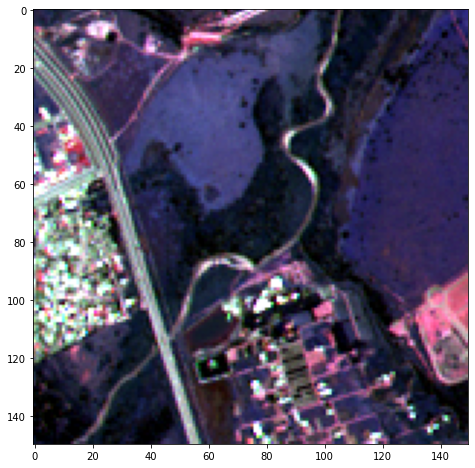

In [ ]:
imshow(multi[100:250,100:250,:4], (2,0,1), stretch = (0.02,0.98))

ImageView object:
  Display bands       :  (2, 0, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [86.56680253623188, 295.2625]
    G: [144.27569444444447, 244.60452961672473]
    B: [118.51647135416667, 229.18091346153844]

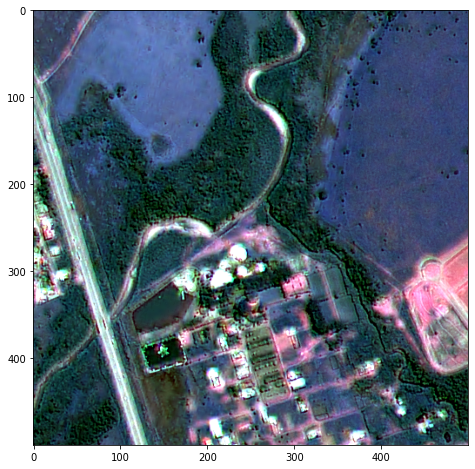

In [ ]:
imshow(fusion[500:1000,500:1000,:4], (2,0,1), stretch = (0.02,0.98))

In [ ]:
# Armazenando diferentes integrações
fusion_IHS = IHS(multi_r, pan_r)
fusion_IHS_SAR = IHS(multi_sar, VH)
fusion_brovey = brovey(multi_r, pan_r, 0.7)
fusion_RCS = RCS(multi_r, pan_r)

In [ ]:
print(fusion_IHS_SAR.shape, VH.shape)

(517, 589, 3) (517, 589)


In [ ]:
from rasterio.plot import reshape_as_raster

fusion_IHS_r = reshape_as_raster(fusion_IHS)
fusion_IHS_SAR_r = reshape_as_raster(fusion_IHS_SAR)
fusion_brovey_r = reshape_as_raster(fusion_brovey)
fusion_RCS_r = reshape_as_raster(fusion_RCS)

In [ ]:
meta_multi.update({'count': 3})

In [ ]:
meta_multi

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 700, 'height': 635, 'count': 3, 'crs': CRS.from_epsg(32722), 'transform': Affine(8.0, 0.0, 720664.0,
       0.0, -8.0, 8197738.0), 'tiled': False, 'interleave': 'pixel'}

In [ ]:
meta_pan['height']

2546

In [ ]:
with rio.open('IHS_SAR.tif', 'w', **meta_multi) as src:
  src.write(fusion_IHS_SAR_r)